In [70]:
import pandas as pd 

In [71]:
df =pd.read_csv('train.csv')

In [72]:
print("orginal",df.shape)

orginal (175000, 17)


In [73]:
invaild_count = (df['total_amount']<=0).sum()
print('Invalid  total_amount rows :',invaild_count)

Invalid  total_amount rows : 1747


In [74]:
df = df[df['total_amount']>0] 

In [75]:
print('Shape after removing invalid fares :',df.shape)

Shape after removing invalid fares : (173253, 17)


### Records with zero or negative total_amount were removed because a taxi fare cannot be negative in real-world scenarios. These values likely represent refunds, cancellations, or data errors and would negatively affect model training.

In [76]:
import numpy as np

In [77]:
print("Missing values before handling:")
df.isna().sum()

for col in df.columns:
    if df[col].dtype in ["int64", "float64"]:
        if df[col].isna().sum() > 0:
            df[col] = df[col].fillna(df[col].median())
    else:
        if df[col].isna().sum() > 0:
            df[col] = df[col].fillna(df[col].mode()[0])

print("\nMissing values after handling:")
print(df.isna().sum())


Missing values before handling:

Missing values after handling:
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
extra                    0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
Airport_fee              0
dtype: int64


In [78]:
def cap_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3-q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return series.clip(lower,upper)


for col in ['total_amount','trip_distance']:
    if col in df.columns:
        df[col] = cap_iqr(df[col])



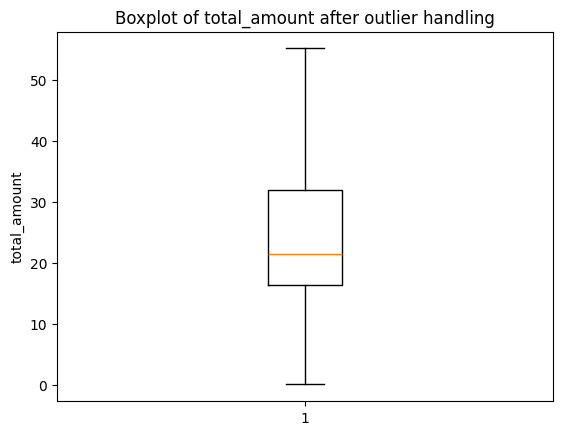

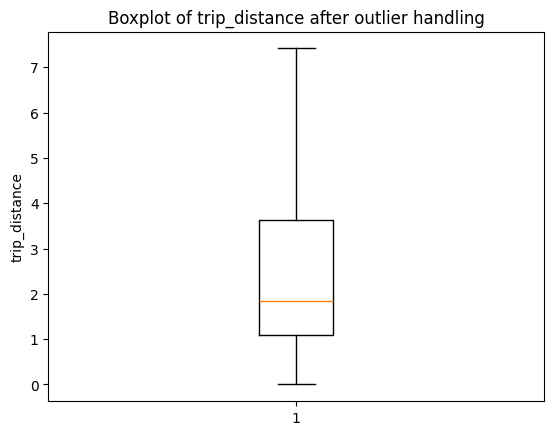

In [79]:
import matplotlib.pyplot as plt

for col in ["total_amount", "trip_distance"]:
    plt.figure()
    plt.boxplot(df[col].dropna())
    plt.title(f"Boxplot of {col} after outlier handling")
    plt.ylabel(col)
    plt.show()


### After applying IQR-based outlier capping to the total_amount feature, the boxplot shows that extreme values have been reduced and the data is now concentrated within a reasonable range. This helps stabilize the distribution and prevents extreme fares from disproportionately influencing the model.

In [80]:
for col in ["tpep_pickup_datetime", "tpep_dropoff_datetime"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")
        df[col + "_hour"] = df[col].dt.hour
        df[col + "_day"] = df[col].dt.day
        df[col + "_month"] = df[col].dt.month

df = df.drop(columns = [c for c in['tpep_pickup_datetime','tpep_dropoff_datetime'] if c in df.columns]) 
print('new columns ',df.columns.tolist())

new columns  ['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'extra', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee', 'tpep_pickup_datetime_hour', 'tpep_pickup_datetime_day', 'tpep_pickup_datetime_month', 'tpep_dropoff_datetime_hour', 'tpep_dropoff_datetime_day', 'tpep_dropoff_datetime_month']


### Datetime features were converted into numerical components such as hour, day, and month. This allows the model to capture temporal patterns like peak hours and daily trends. The original datetime columns were removed since machine learning models cannot directly use raw datetime strings.

In [81]:
cat_col = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:",cat_col)

df_encoded = pd.get_dummies(df,columns=cat_col,drop_first=True)
print("Shape before encoding:", df.shape)
print("Shape after encoding:", df_encoded.shape)

df = df_encoded


Categorical columns: ['store_and_fwd_flag', 'payment_type']
Shape before encoding: (173253, 21)
Shape after encoding: (173253, 24)


### Categorical variables were converted into numerical format using one-hot encoding. This allows machine learning models to process categorical features without assuming any ordinal relationship between categories.

In [82]:
df.dtypes

VendorID                         int64
passenger_count                float64
trip_distance                  float64
RatecodeID                     float64
PULocationID                     int64
DOLocationID                     int64
extra                          float64
tip_amount                     float64
tolls_amount                   float64
improvement_surcharge          float64
total_amount                   float64
congestion_surcharge           float64
Airport_fee                    float64
tpep_pickup_datetime_hour        int32
tpep_pickup_datetime_day         int32
tpep_pickup_datetime_month       int32
tpep_dropoff_datetime_hour       int32
tpep_dropoff_datetime_day        int32
tpep_dropoff_datetime_month      int32
store_and_fwd_flag_Y              bool
payment_type_Credit Card          bool
payment_type_UPI                  bool
payment_type_Wallet               bool
payment_type_unknown              bool
dtype: object

In [83]:
from sklearn.preprocessing import StandardScaler

In [86]:
target = 'total_amount'
x = df.drop(columns=[target])
y = df[target]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

print('shape of scaled features',x_scaled.shape)
print('shape of targt',y.shape)

shape of scaled features (173253, 23)
shape of targt (173253,)


### StandardScaler was used to normalize the feature values so that all features have a mean of 0 and a standard deviation of 1. This is important because many machine learning algorithms are sensitive to the scale of input features, and scaling helps improve training stability and model performance.